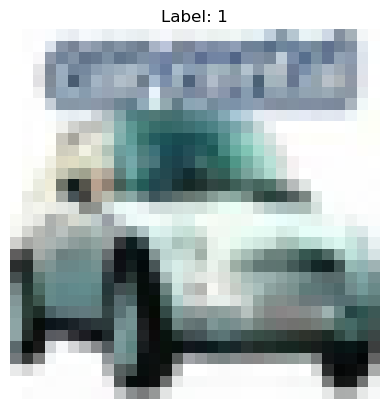

In [ ]:
import numpy as np
import os
import matplotlib.pyplot as plt
import pickle

DATA_PATH = "../data/cifar-10-batches-py" 
IMG_SIZE = 32
NUM_CHANNELS = 3

def unpickle(file):
    with open(file, 'rb') as f:
        dict = pickle.load(f, encoding='bytes')
    return dict

def load_cifar10_batch(path_to_batch):
    batch = unpickle(path_to_batch)
    images = batch[b'data']
    images = images.reshape(-1, NUM_CHANNELS, IMG_SIZE, IMG_SIZE)
    images = np.transpose(images, (0, 2, 3, 1)) # (N, H, W, C)
    labels = batch[b'labels']
    return images, labels

def load_cifar10_data(path_to_data):
    X_train = []
    y_train = []
    for i in range(1, 6):
        images, labels = load_cifar10_batch(os.path.join(path_to_data, f"data_batch_{i}"))
    X_train.append(images)
    y_train.append(labels)
    X_train = np.concatenate(X_train)
    y_train = np.concatenate(y_train)
    X_test, y_test = load_cifar10_batch(os.path.join(path_to_data, "test_batch"))
    return X_train, y_train, X_test, y_test

X_train, y_train, X_test, y_test = load_cifar10_data(DATA_PATH)

plt.imshow(X_train[0])
plt.title(f"Label: {y_train[0]}")
plt.axis('off')
plt.show()


In [ ]:
import cv2
from sklearn import svm
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score

def extract_harris_features(images):
    descriptors_list = []
    for img in images:
        gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        harris_corners = cv2.cornerHarris(gray, blockSize=2, ksize=3, k=0.04)
        keypoints = np.argwhere(harris_corners > 0.01 * harris_corners.max())
        keypoints = [cv2.KeyPoint(float(pt[1]), float(pt[0]), 1) for pt in keypoints]
        sift = cv2.SIFT_create()
        _, descriptors = sift.compute(gray, keypoints)
        if descriptors is not None:
            descriptors_list.append(descriptors)
    return descriptors_list

harris_train_descriptors = extract_harris_features(X_train)
harris_test_descriptors = extract_harris_features(X_test)

all_descriptors = np.vstack(harris_train_descriptors)

num_clusters = 100
kmeans = KMeans(n_clusters=num_clusters)
kmeans.fit(all_descriptors)

def create_histograms(descriptors_list, kmeans):
    histograms = []
    for descriptors in descriptors_list:
        histogram = np.zeros(num_clusters)
        if descriptors is not None:
            cluster_indices = kmeans.predict(descriptors)
            for idx in cluster_indices:
                histogram[idx] += 1
        histograms.append(histogram)
    return np.array(histograms)

train_histograms = create_histograms(harris_train_descriptors, kmeans)
test_histograms = create_histograms(harris_test_descriptors, kmeans)

scaler = StandardScaler()
train_histograms = scaler.fit_transform(train_histograms)
test_histograms = scaler.transform(test_histograms)

svm_model = svm.SVC()
svm_model.fit(train_histograms, y_train)
svm_predictions = svm_model.predict(test_histograms)
svm_accuracy = accuracy_score(y_test, svm_predictions)
print(f"Harris + BoVW + SVM Accuracy: {svm_accuracy}")




/opt/anaconda3/envs/tm/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Harris + BoVW + SVM Accuracy: 0.3702
